In [4]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import scanpy as sc
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import glob
import os
import colorcet
import string
import random
import time

from matplotlib.ticker import FormatStrFormatter
from matplotlib.patches import Patch
from pathlib import Path
from scipy import io
import nmi
colors_to_use_pastel=[(0.5665516830630946, 0.5037138904751852, 0.5075215212500083),
 (0.9949012052279167, 0.7553237006975844, 0.5055095027008268),
 (0.6013710840316495, 0.6764106146805113, 0.9895579386673582),
 (0.998816092724718, 0.7071878014442006, 0.8979090191443285),
 (0.5429870427410571, 0.750719571440085, 0.6124765491924715),
 (0.5084695919264852, 0.5093366344721296, 0.9990436978593071),
 (0.8246194014837736, 0.9846839170837028, 0.5089892119497516),
 (0.5052972476002842, 0.5444186786858283, 0.7812964942323839),
 (0.5124601533942488, 0.9750384643760528, 0.9697621879182152),
 (0.9728598314959997, 0.5013134514042519, 0.8469604310077152)]

palette={alg : colors_to_use_pastel[i] for i,alg in enumerate(["ShareTopic","Mowgli","nSBM"])}

In [6]:
def create_alg(word):
    return word.split("_")[0]
        
def create_data(word):
    return "_".join(word.split("_")[1:])

def find_best_level(results, ground_truth, label="CellType", method="best", metric="NMI/NMI*"):
    ok_levels, exps = {}, {}
    for exp in sorted(set(results["Exp"])):
        ok_levels[exp] = {}
        if method=="CT_clusters":
            for run in range(0,25):
                exps[exp] = {}
                for level in [0,1,2,3]:
                    a=results[(results["Level"]==int(level)) & (results["GT"]==label) & (results["Exp"]==exp) & (results["Run"]==run)][["N_clusters"]]
                    if len(a["N_clusters"]) > 0:
                        exps[exp][str(level)]=float(np.abs(a["N_clusters"]-len(set(ground_truth[label].dropna()))))
                if len(exps[exp]) > 0:
                    ok_levels[exp][run]=np.argmin(pd.DataFrame.from_dict(exps[exp], orient="index").fillna(10000000000))
        elif method=="best":
            for run in range(0,25):
                exps[exp] = {}
                for level in [0,1,2,3]:
                    a=results[(results["Level"]==int(level)) & (results["GT"]==label) & (results["Exp"]==exp) & (results["Run"]==run)][[metric]]
                    if len(a[metric]) > 0:
                        exps[exp][str(level)]=float(a[metric])
                if len(exps[exp]) > 0:
                    ok_levels[exp][run]=np.argmax(pd.DataFrame.from_dict(exps[exp], orient="index").fillna(0))            
    return ok_levels

def create_results(dataset, label, metric="NMI/NMI*"):
    
    SBMs=pd.read_csv(f"Datasets/{dataset}/SBM/{dataset}_SBMs_25Run_NMI.tsv.gz", sep="\t", index_col=0)
    SBMs=SBMs[SBMs["GT"]==label]
    SBMs["Algorithm"]=[create_alg(SBMs.iloc[i]["Exp"]) for i in range(len(SBMs))]
    SBMs["Data"]=[create_data(SBMs.iloc[i]["Exp"]) for i in range(len(SBMs))]
    gt=pd.read_csv(f"Datasets/{dataset}/{dataset}_Metadata.tsv.gz", sep="\t", index_col=0)
    ok_levels_best=find_best_level(SBMs, gt, label=label, method="best", metric=metric)
    ok_levels_nc=find_best_level(SBMs, gt, label=label, method="CT_clusters", metric=metric)


    SBMs_def_best=pd.DataFrame()
    for exp in ok_levels_best.keys():
        for run in ok_levels_best[exp].keys():
            d=SBMs[(SBMs["Exp"]==exp) & (SBMs["Run"]==run) & (SBMs["Level"]==int(ok_levels_best[exp][run]))]
            SBMs_def_best=pd.concat([SBMs_def_best, d])

    SBMs_def_ct=pd.DataFrame()
    for exp in ok_levels_nc.keys():
        for run in ok_levels_nc[exp].keys():
            d=SBMs[(SBMs["Exp"]==exp) & (SBMs["Run"]==run) & (SBMs["Level"]==int(ok_levels_nc[exp][run]))]
            SBMs_def_ct=pd.concat([SBMs_def_ct, d])
    
   
    mowgli=pd.read_csv(f"Datasets/{dataset}/Mowgli/{dataset}_Mowgli_25Run_NMI.tsv.gz", sep="\t", index_col=0)
    mowgli=mowgli[mowgli["GT"]==label]
    mowgli["Algorithm"]="Mowgli"
    mowgli["Data"]=["_".join(mowgli.iloc[i]["Exp"].split("_")[1:]) for i in range(len(mowgli))]    

    if dataset not in ["BMMCCite", "Spleen"]:
        ShareTopic=pd.read_csv(f"Datasets/{dataset}/ShareTopic/{dataset}_ShareTopic_25Run_NMI.tsv.gz", sep="\t", index_col=0)
        ShareTopic=ShareTopic[ShareTopic["GT"]==label]
        ShareTopic["Algorithm"]="ShareTopic"
        ShareTopic["Data"]=["_".join(ShareTopic.iloc[i]["Exp"].split("_")[1:]) for i in range(len(ShareTopic))]
    else:
        ShareTopic=pd.DataFrame()
    
    df_best=pd.concat([SBMs_def_best, ShareTopic, mowgli], axis=0)
    df_best.reset_index(inplace=True)
    df_best.drop("index", axis=1, inplace=True)
    df_best["Data"]=df_best["Data"].replace("_", "+")

    df_ct=pd.concat([SBMs_def_ct, ShareTopic, mowgli], axis=0)
    df_ct.reset_index(inplace=True)
    df_ct.drop("index", axis=1, inplace=True)
    df_ct["Data"]=df_ct["Data"].replace("_", "+")

    return df_best, df_ct

# All datasets

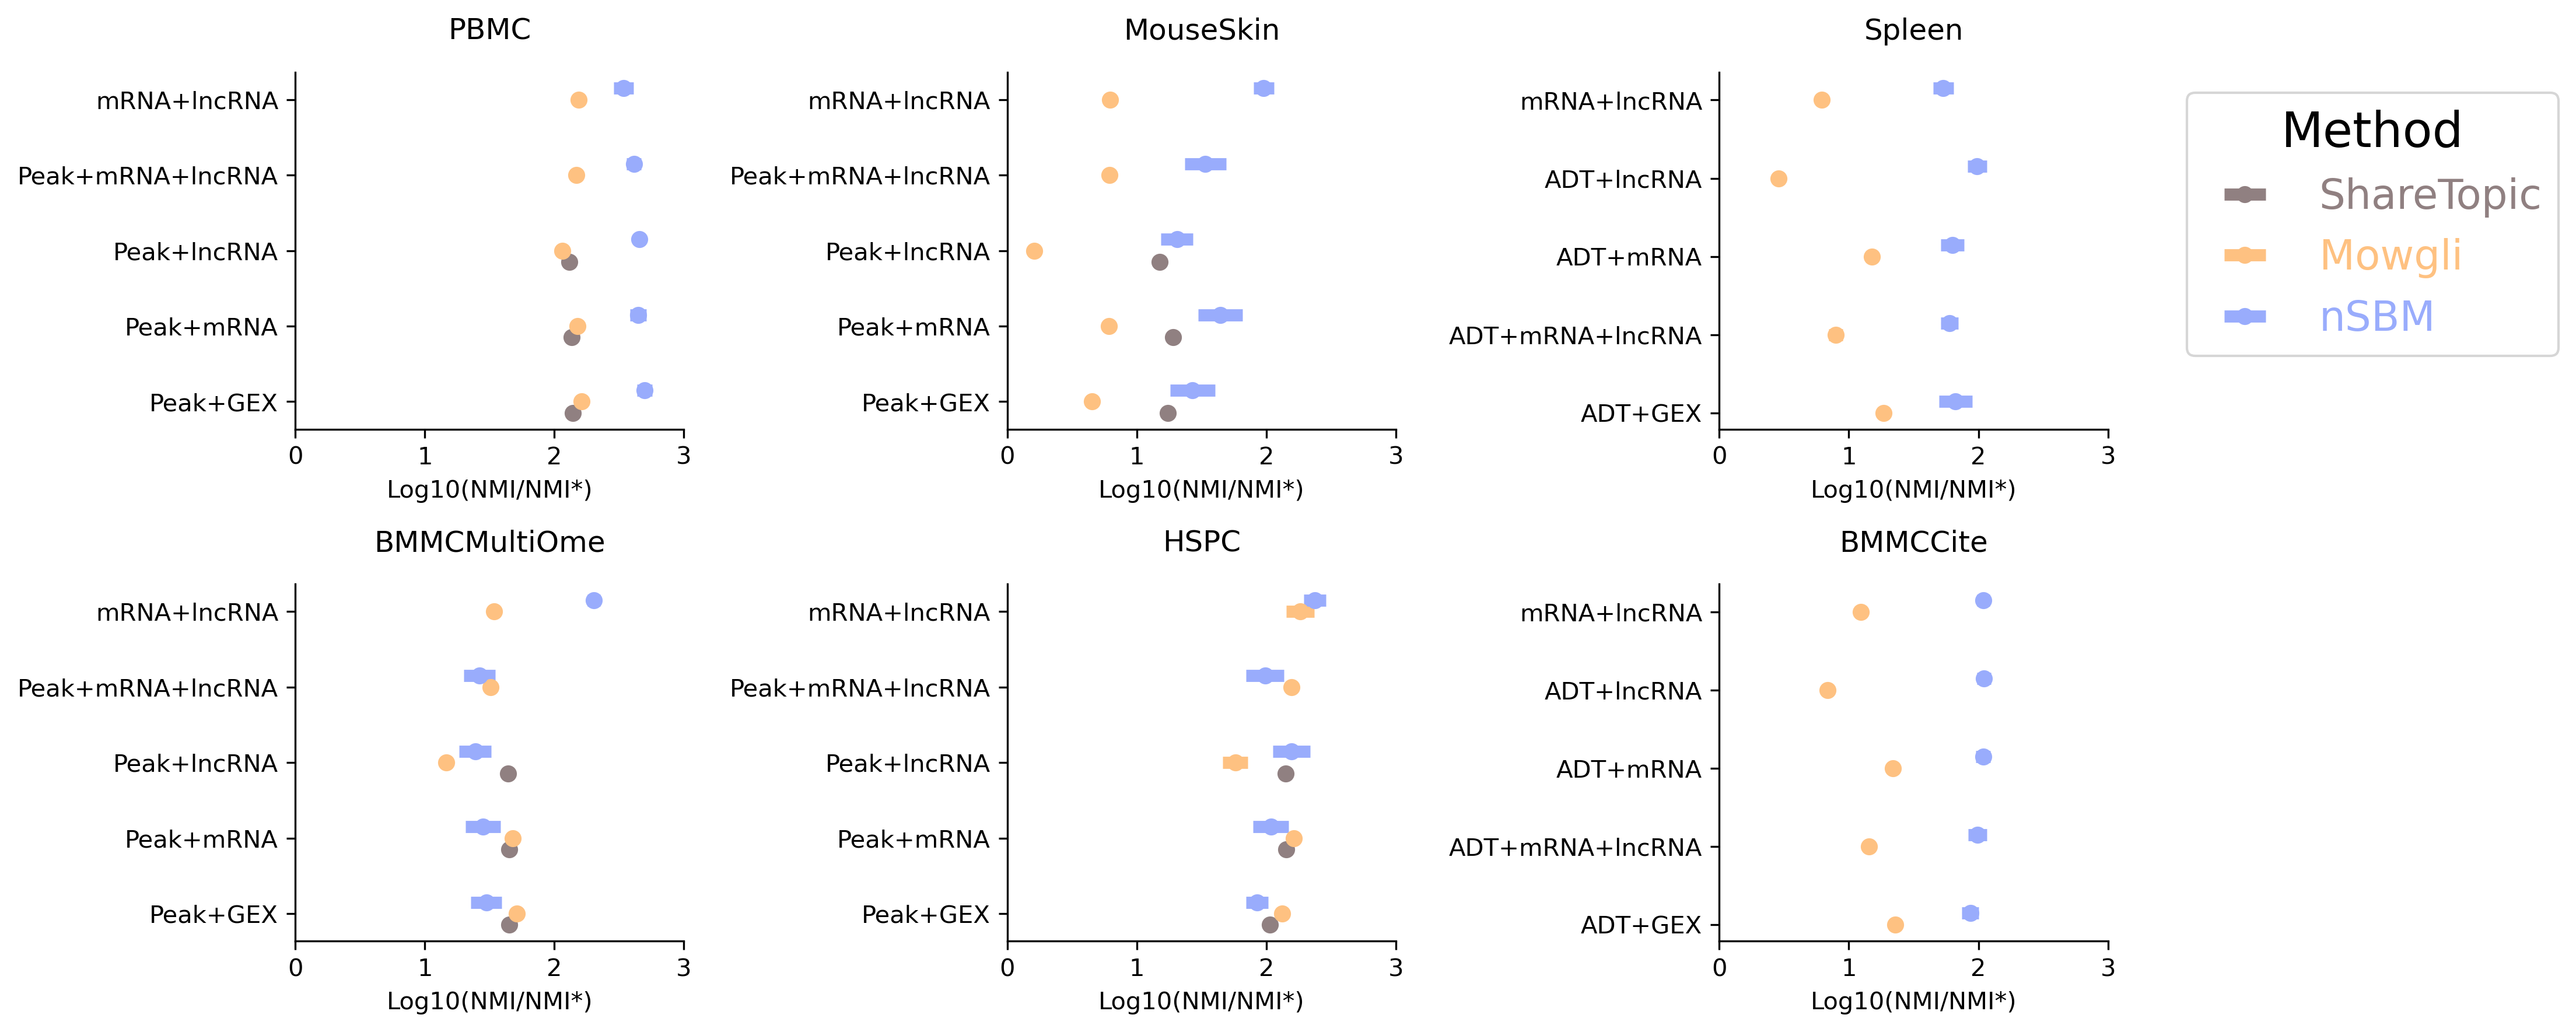

In [7]:
fig, axs = plt.subplots(2,3, figsize=(15,6), dpi=300)
axs=axs.flatten()

for l, dataset in enumerate(["PBMC","MouseSkin", "Spleen","BMMCMultiOme","HSPC","BMMCCite"]):
    if dataset in ["BMMCCite", "Spleen"]:
        order=["ADT+GEX", "ADT+mRNA+lncRNA", "ADT+mRNA", "ADT+lncRNA", "mRNA+lncRNA"]
    else:
        order=["Peak+GEX", "Peak+mRNA", "Peak+lncRNA","Peak+mRNA+lncRNA", "mRNA+lncRNA"]

    df_best=create_results(dataset, "CellType")[0].replace({"_" : "+"}, regex=True)
    df_best["log10(NMI/NMI*)"]=np.log10(df_best["NMI/NMI*"])
    
    for i, exp in enumerate(palette.keys()):
        d = df_best[df_best["Algorithm"] == exp]
        
        # Means and SEMs
        means = d.groupby("Exp")["log10(NMI/NMI*)"].mean()
        sems = 3 * d.groupby("Exp")["log10(NMI/NMI*)"].sem()
        new_order_temp=["+".join(o.split("+")[1:]) for o in list(d.groupby("Exp")["log10(NMI/NMI*)"].mean().index)]
        means.index=new_order_temp
        sems.index=new_order_temp
        # Only keep experiments present in `order`
        exps_present = [o for o in order if o in means.index]
        
        # Map to numeric y-positions from the global order
        y_positions = np.array([order.index(o) for o in exps_present], dtype=float)
        
        # Add small vertical offset per method to avoid overlap
        offset = (i - (len(palette) - 1) / 2) * 0.15
        y_positions += offset
        axs[l].errorbar(x=means[exps_present], y=y_positions, xerr=sems[exps_present], ls='none', ecolor=palette[exp], 
                        elinewidth=5, marker="o", c=palette[exp], label=exp)

    # Set axis labels and limits
    axs[l].set_title(dataset, y=1.05)
    axs[l].set_xlim([0, 3])
    axs[l].set_yticks(range(len(order)))
    axs[l].set_yticklabels(order)
    axs[l].spines['top'].set_visible(False)
    axs[l].spines['right'].set_visible(False)  
    axs[l].spines['bottom'].set_visible(True)
    axs[l].spines['left'].set_visible(True)  

handles, labels = axs[2].get_legend_handles_labels()
axs[2].legend(handles, labels, bbox_to_anchor=(1.15, 1), title="Method", fontsize=17,  
              title_fontsize=20, labelcolor=[palette[key] for key in labels])
for ax in axs:
    ax.set_xlabel("Log10(NMI/NMI*)")
fig.tight_layout()
plt.savefig(f"Figures/Figure2.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

# NMI vs MDL

In [ ]:
data=pd.DataFrame(columns=["Dataset","Exp","Pearson"])
for l, dataset in enumerate(["BMMCCite","MouseSkin","BMMCMultiOme", "Spleen", "PBMC","HSPC"]):
    if dataset in ["BMMCCite", "Spleen"]:
        order=["ADT+GEX", "ADT+mRNA+lncRNA", "ADT+mRNA", "ADT+lncRNA", "mRNA+lncRNA"]
    else:
        order=["Peak+GEX","Peak+mRNA+lncRNA", "Peak+mRNA", "Peak+lncRNA", "mRNA+lncRNA"]

    df_best=create_results(dataset, "CellType")[0].replace({"_" : "+"}, regex=True)
    df_best["log10(NMI/NMI*)"]=np.log10(df_best["NMI/NMI*"])
    d=df_best[df_best["Algorithm"]=="nSBM"]

#    sns.scatterplot(data=d, x="MDL", y="log10(NMI/NMI*)", ax=axs[l])
    for exp in set(d["Exp"]):
        try:
            data=pd.concat([data, pd.DataFrame(index=data.columns, data=[dataset, exp, scipy.stats.pearsonr(d[d["Exp"]==exp]["MDL"], d[d["Exp"]==exp]["log10(NMI/NMI*)"])[0]]).T])
        except:
            print("Problem with", dataset, exp)

In [ ]:
sns.boxplot(data=data, y="Dataset", x="Pearson")
plt.xlim([-1,1])

In [ ]:
sns.boxplot(data=data, y="Exp", x="Pearson")
plt.xlim([-1,1])

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(15,6), dpi=300)
axs=axs.flatten()

for l, dataset in enumerate(["BMMCCite","MouseSkin","BMMCMultiOme", "Spleen", "PBMC","HSPC"]):
    if dataset in ["BMMCCite", "Spleen"]:
        order=["ADT+GEX", "ADT+mRNA+lncRNA", "ADT+mRNA", "ADT+lncRNA", "mRNA+lncRNA"]
    else:
        order=["Peak+GEX","Peak+mRNA+lncRNA", "Peak+mRNA", "Peak+lncRNA", "mRNA+lncRNA"]

    df_best=create_results(dataset, "CellType")[0].replace({"_" : "+"}, regex=True)
    df_best["log10(NMI/NMI*)"]=np.log10(df_best["NMI/NMI*"])
    d=df_best[df_best["Algorithm"]=="nSBM"]
    dfs=[]
    for exp in set(d["Exp"]):
        red=d[d["Exp"]==exp]
        red["MDL"]=(red["MDL"]-red["MDL"].min())/(red["MDL"].max()-red["MDL"].min())
        dfs.append(red)
    d=pd.concat(dfs)
    sns.scatterplot(data=d, x="MDL", y="log10(NMI/NMI*)", hue="Exp", ax=axs[l])
    axs[l].set_title(dataset)
    axs[l].set_xlim([0,1])
    axs[l].set_ylim([0,3])
    if l != 5:
        axs[l].legend().remove()
    else:
        handles, labels = axs[l].get_legend_handles_labels()
        labels=[l.replace("Peak"," * ") for l in labels]
        axs[l].legend(handles, labels, bbox_to_anchor=(1.15, 1), title="Experiment", fontsize=11,  
              title_fontsize=15)
        
fig.tight_layout()
plt.savefig(f"Figures/nSBM_MDL_vs_NMI.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(15,6), dpi=300)
axs=axs.flatten()

for l, dataset in enumerate(["BMMCCite","MouseSkin","BMMCMultiOme", "Spleen", "PBMC","HSPC"]):
    if dataset in ["BMMCCite", "Spleen"]:
        order=["ADT+GEX", "ADT+mRNA+lncRNA", "ADT+mRNA", "ADT+lncRNA", "mRNA+lncRNA"]
    else:
        order=["Peak+GEX","Peak+mRNA+lncRNA", "Peak+mRNA", "Peak+lncRNA", "mRNA+lncRNA"]

    df_best=create_results(dataset, "CellType")[0].replace({"_" : "+"}, regex=True)
    d=df_best[df_best["Algorithm"]=="nSBM"]
    dfs=[]
    for exp in set(d["Exp"]):
        red=d[d["Exp"]==exp]
        red["MDL"]=(red["MDL"]-red["MDL"].min())/(red["MDL"].max()-red["MDL"].min())
        dfs.append(red)
    d=pd.concat(dfs)
    means=np.array(d.groupby("Data")["MDL"].mean())
    sems=np.array(d.groupby("Data")["MDL"].std())
    x=np.array(pd.DataFrame(data=[means, sems], columns=order, index=["mean","sem"]).T.loc[order]["mean"])
    xerr=np.array(pd.DataFrame(data=[means, sems], columns=order, index=["mean","sem"]).T.loc[order]["sem"])
    axs[l].errorbar(x=x, y=order, xerr=xerr, ls='none', ecolor=palette["nSBM"], elinewidth=5, marker="o", c=palette["nSBM"])
    axs[l].set_xlim([0,1])
       
fig.tight_layout()
plt.savefig(f"Figures/nSBM_MDL_sample_variance.png", format="png", dpi=300, bbox_inches='tight')
plt.show()

# Silhouette

In [ ]:
fig, axs = plt.subplots(2,3, figsize=(15,6), dpi=300)
axs=axs.flatten()
metric="SilClust"

for l, dataset in enumerate(["BMMCCite","MouseSkin","BMMCMultiOme", "Spleen", "PBMC","HSPC"]):
    if dataset in ["BMMCCite", "Spleen"]:
        order=["ADT+GEX", "ADT+mRNA+lncRNA", "ADT+mRNA", "ADT+lncRNA", "mRNA+lncRNA"]
    else:
        order=["Peak+GEX","Peak+mRNA+lncRNA", "Peak+mRNA", "Peak+lncRNA", "mRNA+lncRNA"]

    df_best=create_results(dataset, "CellType", metric=metric)[0].replace({"_" : "+"}, regex=True)
    
    for i, exp in enumerate(palette.keys()):
        d=df_best[df_best["Algorithm"]==exp]
        new_order_temp=["+".join(o.split("+")[1:]) for o in list(d.groupby("Exp")[metric].mean().index)]
        new_order = [o for o in order if o in new_order_temp]
        means=np.array(d.groupby("Exp")[metric].mean())
        sems=3*np.array(d.groupby("Exp")[metric].sem())
        x=np.array(pd.DataFrame(data=[means, sems], columns=new_order_temp, index=["mean","sem"]).T.loc[new_order]["mean"])
        xerr=np.array(pd.DataFrame(data=[means, sems], columns=new_order_temp, index=["mean","sem"]).T.loc[new_order]["sem"])
        axs[l].errorbar(x=x, y=new_order, xerr=xerr, ls='none', ecolor=palette[exp], 
                        elinewidth=5, marker="o", c=palette[exp], label=exp)

    axs[l].set_title(dataset)
handles, labels = axs[2].get_legend_handles_labels()
axs[2].legend(handles, labels, bbox_to_anchor=(1.15, 1), title="Method", fontsize=17,  
              title_fontsize=20, labelcolor=[palette[key] for key in labels])
for ax in axs:
    ax.set_xlabel(metric)
fig.tight_layout()
plt.savefig(f"Figures/AllMethods_Silhouette_25Runs_best.png", format="png", dpi=300, bbox_inches='tight')
plt.show()